In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [54]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('axes', linewidth = 3.)

load data

In [3]:
n_rois = 68
count_offset = 100
data_path = '../sample_data/'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path+'abcd_data.npy')
n_subs = brain_networks.shape[0]

In [4]:
std_trans = min_max_standardize(np.log(avg_trans))
std_rotat = min_max_standardize(np.log(avg_rotat))
motion = np.concatenate([std_trans, std_rotat], axis=-1)

In [7]:
with open(data_path+'abcd_traits_dict.txt') as f:
    lines = f.readlines()
f.close()

In [9]:
pic_vocab = traits[:,1]
oral_reading = traits[:,4]
cryst_comp = traits[:,9]
fluid_comp = traits[:,7]
total_comp = traits[:,11]

In [42]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .01, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=100, lr=1e-5, device=DEVICE)

In [11]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [43]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(cryst_comp).to(torch.float32) 

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

7781 865


vae

In [44]:
cryst_comp_vae = VAE(config).to(config.device)
cryst_comp_vae.apply(reset_weights)
cryst_comp_vae.set_mask(knn_masks)
optimizer = optim.Adam(cryst_comp_vae.parameters(), lr=config.lr) 

In [45]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = cryst_comp_vae.reg_train(epoch, train_loader, cryst_comp_vae, optimizer, config.device, n_epoch_display=5)
    val_loss = cryst_comp_vae.reg_test(epoch, val_loader, cryst_comp_vae, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 4126.695 nll: -1312.562 kl: 4364.042 rmse: 12.110
epoch: 0 test loss: -1370.784 nll: -2310.242 kl: 14043.495 rmse: 4.932
epoch: 5 train loss: -1595.889 nll: -2359.126 kl: 14212.569 rmse: 4.360
epoch: 5 test loss: -1655.540 nll: -2388.300 kl: 13800.267 rmse: 4.260
epoch: 10 train loss: -1750.063 nll: -2370.456 kl: 13056.410 rmse: 3.872
epoch: 10 test loss: -1792.713 nll: -2399.888 kl: 12695.244 rmse: 3.834
epoch: 15 train loss: -1865.364 nll: -2406.393 kl: 12114.757 rmse: 3.582
epoch: 15 test loss: -1882.636 nll: -2433.756 kl: 11763.890 rmse: 3.632
epoch: 20 train loss: -1935.421 nll: -2434.228 kl: 11269.940 rmse: 3.434
epoch: 20 test loss: -1931.293 nll: -2455.767 kl: 10955.031 rmse: 3.553
epoch: 25 train loss: -1981.285 nll: -2451.425 kl: 10481.100 rmse: 3.340
epoch: 25 test loss: -1965.689 nll: -2471.983 kl: 10201.355 rmse: 3.508
epoch: 30 train loss: -2017.858 nll: -2467.239 kl: 9842.035 rmse: 3.274
epoch: 30 test loss: -1993.651 nll: -2486.601 kl: 9578.070 rmse

inv_vae

In [48]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0., 
    beta = .01, gamma = .01, add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=200, lr=2e-5, device=DEVICE)

In [49]:
cryst_comp_inv = INV_VAE(config).to(config.device)
cryst_comp_inv.apply(reset_weights)
cryst_comp_inv.set_mask(knn_masks)
optimizer = optim.Adam(cryst_comp_inv.parameters(), lr=config.lr) 

In [50]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = cryst_comp_inv.reg_train(epoch, train_loader, cryst_comp_inv, optimizer, config.device, n_epoch_display=5)
    val_loss = cryst_comp_inv.reg_test(epoch, val_loader, cryst_comp_inv, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 3075.985 nll: -1844.894 kl: 12318.349 inv_loss: 2.855 rmse: 8.446
epoch: 0 test loss 640.264 nll: -2364.221 kl: 48382.561 inv_loss: 31.082 rmse: 4.483
epoch: 5 train loss: 448.497 nll: -2362.486 kl: 46415.068 inv_loss: 1.611 rmse: 3.801
epoch: 5 test loss 434.161 nll: -2393.059 kl: 2159068.699 inv_loss: 42.239 rmse: 3.740
epoch: 10 train loss: 365.814 nll: -2383.504 kl: 88790.220 inv_loss: 2.450 rmse: 3.451
epoch: 10 test loss 402.890 nll: -2411.315 kl: 29793469.212 inv_loss: 813.676 rmse: 3.538
epoch: 15 train loss: 333.747 nll: -2399.516 kl: 83667.438 inv_loss: 2.913 rmse: 3.306
epoch: 15 test loss 375.730 nll: -2424.966 kl: 6208108.167 inv_loss: 274.729 rmse: 3.469
epoch: 20 train loss: 315.333 nll: -2409.338 kl: 88463.211 inv_loss: 3.095 rmse: 3.221
epoch: 20 test loss 395.258 nll: -2435.750 kl: 55349132.137 inv_loss: 1588.622 rmse: 3.442
epoch: 25 train loss: 302.177 nll: -2415.627 kl: 101957.704 inv_loss: 3.249 rmse: 3.158
epoch: 25 test loss 372.248 nll: -24

plotting

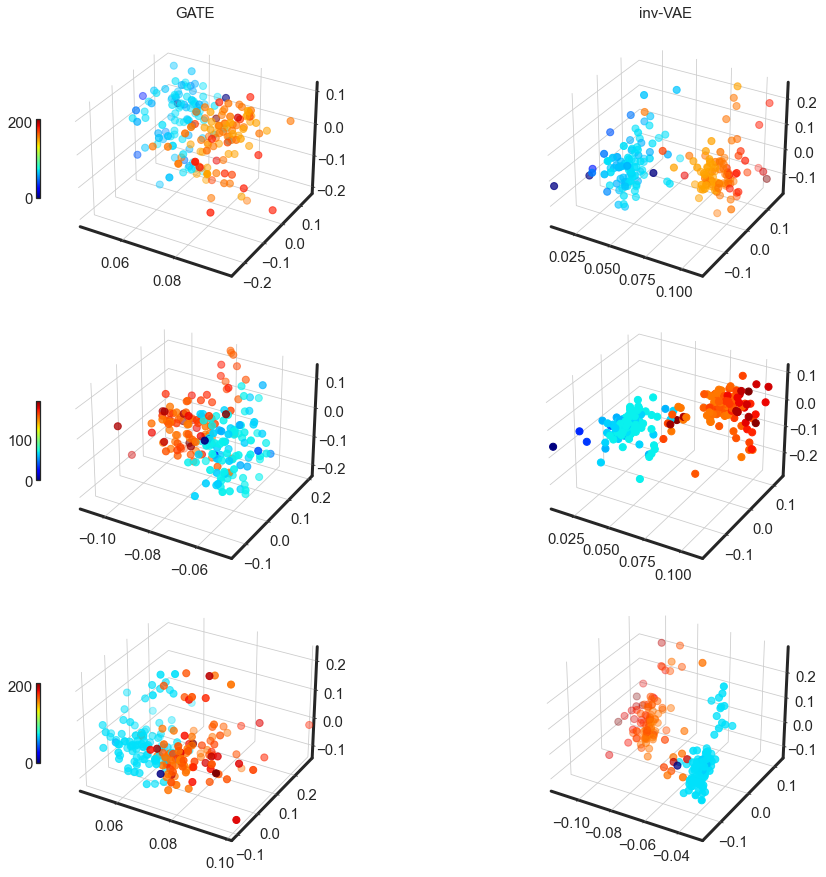

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True, subplot_kw=dict(projection='3d'))
plt.style.use('seaborn-white')

################## pic vocab - vae ##################
pic_vocab_vae_z_mean, _ = pic_vocab_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, pic_vocab_vae_y_pred, _, _ = pic_vocab_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
pic_vocab_vae_y_pred = pic_vocab_vae_y_pred.detach().cpu().numpy()

pic_vocab_y_ids = np.argsort(pic_vocab)
pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

pic_vocab_vae_z_mean_sub = pic_vocab_vae_z_mean[pic_vocab_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(pic_vocab_vae_z_mean_sub.transpose())
pic_vocab_vae_pcs = pca.components_.transpose()

p1 = axes[0,0].scatter(pic_vocab_vae_pcs[:,0], pic_vocab_vae_pcs[:,1], pic_vocab_vae_pcs[:,2], c=pic_vocab_vae_colors, cmap = 'jet', s = 50)
cb = fig.colorbar(p1, ax=axes[0,0], location='left', fraction=0.01)
axes[0,0].set_title('GATE')
axes[0,0].set_xlim3d(min(pic_vocab_vae_pcs[:,0]), max(pic_vocab_vae_pcs[:,0]))
axes[0,0].set_ylim3d(min(pic_vocab_vae_pcs[:,1]), max(pic_vocab_vae_pcs[:,1]))
axes[0,0].set_zlim3d(min(pic_vocab_vae_pcs[:,2]), max(pic_vocab_vae_pcs[:,2]))

################## pic vocab - inv_vae ##################
pic_vocab_inv_z_mean, _ = pic_vocab_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, pic_vocab_inv_y_pred, _, _ = pic_vocab_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
pic_vocab_inv_y_pred = pic_vocab_inv_y_pred.detach().cpu().numpy()

pic_vocab_y_ids = np.argsort(pic_vocab)
pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

pic_vocab_inv_z_mean_sub = pic_vocab_inv_z_mean[pic_vocab_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(pic_vocab_inv_z_mean_sub.transpose())
pic_vocab_inv_pcs = pca.components_.transpose()

p2 = axes[0,1].scatter(pic_vocab_inv_pcs[:,0], pic_vocab_inv_pcs[:,1], pic_vocab_inv_pcs[:,2], c=pic_vocab_vae_colors, cmap = 'jet', s = 50)
axes[0,1].set_title('inv-VAE')
axes[0,1].set_xlim3d(min(pic_vocab_inv_pcs[:,0]), max(pic_vocab_inv_pcs[:,0]))
axes[0,1].set_ylim3d(min(pic_vocab_inv_pcs[:,1]), max(pic_vocab_inv_pcs[:,1]))
axes[0,1].set_zlim3d(min(pic_vocab_inv_pcs[:,2]), max(pic_vocab_inv_pcs[:,2]))


################## card sort - vae ##################
cryst_comp_vae_z_mean, _ = cryst_comp_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, cryst_comp_vae_y_pred, _, _ = cryst_comp_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
cryst_comp_vae_y_pred = cryst_comp_vae_y_pred.detach().cpu().numpy()

cryst_comp_y_ids = np.argsort(cryst_comp)
cryst_comp_y_sub_ids = np.concatenate([cryst_comp_y_ids[:100], cryst_comp_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
cryst_comp_vae_colors = cryst_comp[cryst_comp_y_sub_ids]

cryst_comp_vae_z_mean_sub = cryst_comp_vae_z_mean[cryst_comp_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(cryst_comp_vae_z_mean_sub.transpose())
cryst_comp_vae_pcs = pca.components_.transpose()

p3 = axes[1,0].scatter(cryst_comp_vae_pcs[:,0], cryst_comp_vae_pcs[:,1], cryst_comp_vae_pcs[:,2], 
                       c=cryst_comp_vae_colors, cmap = 'jet', s = 50)
cb = fig.colorbar(p3, ax=axes[1,0], location='left', fraction=0.01)
axes[1,0].set_xlim3d(min(cryst_comp_vae_pcs[:,0]), max(cryst_comp_vae_pcs[:,0]))
axes[1,0].set_ylim3d(min(cryst_comp_vae_pcs[:,1]), max(cryst_comp_vae_pcs[:,1]))
axes[1,0].set_zlim3d(min(cryst_comp_vae_pcs[:,2]), max(cryst_comp_vae_pcs[:,2]))


################## card sort - inv_vae ##################
cryst_comp_inv_z_mean, _ = cryst_comp_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, cryst_comp_inv_y_pred, _, _ = cryst_comp_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
cryst_comp_inv_y_pred = cryst_comp_inv_y_pred.detach().cpu().numpy()

cryst_comp_y_ids = np.argsort(cryst_comp)
cryst_comp_y_sub_ids = np.concatenate([cryst_comp_y_ids[:100], cryst_comp_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
cryst_comp_vae_colors = cryst_comp[cryst_comp_y_sub_ids]

cryst_comp_inv_z_mean_sub = cryst_comp_inv_z_mean[cryst_comp_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(cryst_comp_inv_z_mean_sub.transpose())
cryst_comp_inv_pcs = pca.components_.transpose()

p4 = axes[1,1].scatter(cryst_comp_inv_pcs[:,0], cryst_comp_inv_pcs[:,1], cryst_comp_inv_pcs[:,2], c=cryst_comp_vae_colors, 
                       cmap = 'jet', s = 50, alpha=1.)
axes[1,1].set_xlim3d(min(cryst_comp_inv_pcs[:,0]), max(cryst_comp_inv_pcs[:,0]))
axes[1,1].set_ylim3d(min(cryst_comp_inv_pcs[:,1]), max(cryst_comp_inv_pcs[:,1]))
axes[1,1].set_zlim3d(min(cryst_comp_inv_pcs[:,2]), max(cryst_comp_inv_pcs[:,2]))


################## oral reading - vae ##################
oral_reading_vae_z_mean, _ = oral_reading_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, oral_reading_vae_y_pred, _, _ = oral_reading_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
oral_reading_vae_y_pred = oral_reading_vae_y_pred.detach().cpu().numpy()

oral_reading_y_ids = np.argsort(oral_reading)
oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

oral_reading_vae_z_mean_sub = oral_reading_vae_z_mean[oral_reading_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(oral_reading_vae_z_mean_sub.transpose())
oral_reading_vae_pcs = pca.components_.transpose()

p5 = axes[2,0].scatter(oral_reading_vae_pcs[:,0], oral_reading_vae_pcs[:,1], oral_reading_vae_pcs[:,2], c=oral_reading_vae_colors, cmap = 'jet', s = 50)
plt.colorbar(p5, ax=axes[2,0], location='left', fraction=0.01)
axes[2,0].set_xlim3d(min(oral_reading_vae_pcs[:,0]), max(oral_reading_vae_pcs[:,0]))
axes[2,0].set_ylim3d(min(oral_reading_vae_pcs[:,1]), max(oral_reading_vae_pcs[:,1]))
axes[2,0].set_zlim3d(min(oral_reading_vae_pcs[:,2]), max(oral_reading_vae_pcs[:,2]))


################## oral reading - inv_vae ##################
oral_reading_inv_z_mean, _ = oral_reading_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, oral_reading_inv_y_pred, _, _ = oral_reading_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
oral_reading_inv_y_pred = oral_reading_inv_y_pred.detach().cpu().numpy()

oral_reading_y_ids = np.argsort(oral_reading)
oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

oral_reading_inv_z_mean_sub = oral_reading_inv_z_mean[oral_reading_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(oral_reading_inv_z_mean_sub.transpose())
oral_reading_inv_pcs = pca.components_.transpose()

p6 = axes[2,1].scatter(oral_reading_inv_pcs[:,0], oral_reading_inv_pcs[:,1], oral_reading_inv_pcs[:,2], c=oral_reading_vae_colors, cmap = 'jet', s = 50)
axes[2,1].set_xlim3d(min(oral_reading_inv_pcs[:,0]), max(oral_reading_inv_pcs[:,0]))
axes[2,1].set_ylim3d(min(oral_reading_inv_pcs[:,1]), max(oral_reading_inv_pcs[:,1]))
axes[2,1].set_zlim3d(min(oral_reading_inv_pcs[:,2]), max(oral_reading_inv_pcs[:,2]))

for i in range(3):
    for j in range(2):
        axes[i,j].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.savefig('saved_figs/fig8_abcd_trait_latents.png', facecolor='white', dpi=800)
plt.show()